# Take Home Test

## Name: Gabriel Nazario
## Position: Data Scientist - Analytics

This document is part of a take-home test for XYZ. The goal is to use linear regression to predict the consumption, in kWh, of energy. <br>
The response variable, Y, is the column KWH.

### Data insights:

This document has more than 900 columns and is a high-dimensional dataset. <br>
Upon checking the data there are columns with no information, labelled "Not Applicable", [-2]. <br>
Z-flags indicate the imputed data. The documentation recommends using them to avoid biased estimations. <br>
Imputed data also has no missing data, that might apply to other variables. <br>
Some data columns are categorical, changing the dtype that might help free some memory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pandas_profiling import ProfileReport

%matplotlib inline

plt.style.use('ggplot')
response = 'KWH'

In [2]:
df = pd.read_csv('../input/residential-energy-consumption-survey/recs2009_public.csv', low_memory=False)

In [3]:
df_description = pd.read_csv('../input/residential-energy-consumption-survey/public_layout.csv', usecols=[0,1], header=0, names=['var_name', 'var_desc'])

Let's create a function to get the description of the variables.

In [4]:
def get_description(col):
    return df_description['var_desc'][df_description['var_name'] == col]

In [5]:
get_description('DOEID')

0    Unique identifier for each respondent
Name: var_desc, dtype: object

In [6]:
df.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,1,2,4,12,2,2471.679705,4742,1080,4953,1271,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,2,4,10,26,2,8599.172010,2662,199,2688,143,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,3,1,1,1,5,8969.915921,6233,505,5741,829,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,4,2,3,7,2,18003.639600,6034,672,5781,868,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,5,1,1,1,3,5999.605242,5388,702,5313,797,...,0,1,1,0,-2,-2,-2,-2,-2,-2


In [7]:
df.tail()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
12078,12079,2,3,9,2,10219.802880,7671,332,7784,451,...,0,3,5,3,-2,-2,-2,-2,-2,-2
12079,12080,3,7,21,4,8689.074445,2085,2844,2520,2286,...,0,1,1,0,-2,-2,-2,-2,-2,-2
12080,12081,2,4,10,2,4697.213624,7935,472,8074,600,...,0,1,1,0,-2,-2,-2,-2,-2,-2
12081,12082,4,8,23,2,13155.678790,5834,770,5989,957,...,0,1,1,0,-2,-2,-2,-2,-2,-2
12082,12083,4,10,26,2,7703.426315,2806,124,2859,139,...,0,1,1,0,-2,-2,-2,-2,-2,-2


### Feature Selection

First, we need to assess which columns have a higher correlation with the Y column, KHW. This will help remove all columns with predominant '-2' and all z-input columns as well.

I will use the CFS, Correlation-based Feature Selection, where only the features with higher correlation with Y will be carried over.

Sources: <br>
https://researchcommons.waikato.ac.nz/bitstream/handle/10289/1024/uow-cs-wp-2000-08.pdf?sequence=1&isAllowed=y <br>
https://faculty.washington.edu/ddbrewer/s231/s231regr.htm

Moderate thresholds start at 0.4

We will start removing the mostly columns with constant values, specially '-2' answers.

I chose 0.9 trying to be conservative. Other studies use lower thresholds to drop full columns with NA values. <br>

In [8]:
to_drop = [col for col in df if (df[col].value_counts(normalize= True).max() > 0.90) ]

print("{} dependent variables to be removed.".format(len(to_drop)))

547 dependent variables to be removed.


In [9]:
to_drop

['CONDCOOP',
 'CONVERSION',
 'ORIG1FAM',
 'LOOKLIKE',
 'TYPEHUQ4',
 'PCTBSTHT',
 'BASECL2',
 'PCTBSTCL',
 'FINATTRMS',
 'ATTCHT2',
 'PCTATTHT',
 'ATTCCL2',
 'PCTATTCL',
 'ZKOWNRENT',
 'ZCONDCOOP',
 'ZYEARMADERANGE',
 'ZOCCUPYYRANGE',
 'ZCONVERSION',
 'ZORIG1FAM',
 'ZLOOKLIKE',
 'ZNUMFLRS',
 'ZNUMAPTS',
 'ZWALLTYPE',
 'ZROOFTYPE',
 'ZSTUDIO',
 'ZNAPTFLRS',
 'ZSTORIES',
 'ZTYPEHUQ4',
 'ZBEDROOMS',
 'ZNCOMBATH',
 'ZNHAFBATH',
 'ZOTHROOMS',
 'ZCELLAR',
 'ZCRAWL',
 'ZCONCRETE',
 'ZBASEFIN',
 'ZFINBASERMS',
 'ZBASEHEAT',
 'ZBASEHT2',
 'ZPCTBSTHT',
 'ZBASECOOL',
 'ZBASECL2',
 'ZPCTBSTCL',
 'ZBASEUSE',
 'ZATTIC',
 'ZATTICFIN',
 'ZFINATTRMS',
 'ZATTCHEAT',
 'ZATTCHT2',
 'ZPCTATTHT',
 'ZATTCCOOL',
 'ZPCTATTCL',
 'ZATTCCL2',
 'ZATTICUSE',
 'ZPRKGPLC1',
 'ZSIZEOFGARAGE',
 'ZGARGLOC',
 'ZGARGHEAT',
 'ZGARGCOOL',
 'ZPRKGPLC2',
 'ZSIZEOFDETACH',
 'MICRO',
 'TOPGRILL',
 'STGRILA',
 'REFRIGT1',
 'HELPFRIY',
 'TYPERFR3',
 'SIZRFRI3',
 'REFRIGT3',
 'MONRFRI3',
 'AGERFRI3',
 'ESFRIG3',
 'REPLCFRZ',
 'HELP

In [10]:
df.drop(labels=to_drop, axis=1, inplace=True)

How many columns do we have now?

In [11]:
print("{} columns left.".format(len(df.columns)))

384 columns left.


Looks like we have some Columns that are similar to KWH, starting with BTUEL. We can remove those since they are the same and that can leak information and make our model 'cheat'. <br><br>
In addition to that we have multicolinearity, variables that come in sets and they are dependend from each other, for example, if you don't have a TV they will not ask how long it stays on. Some of them might have a strong correlation.

Let's start removing the entries with 'BTU' and 'DOL', they represent the metric in another unit (BTU) and in Dolars, respectively. Dollar amount is calculated using KWH and rate, we can remove those, since correlation already is expected.

Eliminate some columns upfront by creating a list of columns that contain the word BTUEL or the ones that contain 'KWH'.

In [12]:
cheat_col = [c for c in df.columns if (("KWH" in c and len(c)>3) or "BTUEL" in c) ]
df.drop(columns=cheat_col,inplace=True)

In [13]:
high_corr_df = pd.DataFrame(df.corr().abs().unstack().sort_values(ascending=False).reset_index())
high_corr_df.rename(columns={'level_0': 'Attribute_1',
                    'level_1' : 'Attribute_2',
                    0 : 'Corr'}, errors= 'raise', inplace=True)

Remove correlation == 1 when attribute on column 1 is the same that column 2, then remove anything smaller than 0.4.

In [14]:
corr_thresh = 0.4
high_corr_df = high_corr_df[(high_corr_df['Attribute_1'] != high_corr_df['Attribute_2']) & (high_corr_df['Corr'].abs() >= corr_thresh)]

In [15]:
high_corr_df.set_index('Attribute_1', inplace=True)
high_corr_df.loc['KWH']

,Attribute_2,Corr
Attribute_1,,
KWH,DOLLAREL,0.868712
KWH,DOLELOTH,0.702252
KWH,TOTALBTUOTH,0.676108
KWH,TOTALDOLOTH,0.655742
KWH,TOTALBTUCOL,0.655103
KWH,TOTALBTURFG,0.638621
KWH,TOTALDOL,0.627922
KWH,TOTALDOLCOL,0.601628
KWH,DOLELCOL,0.601626


In [16]:
high_corr_df.loc[high_corr_df.index.str.contains('KWH') & high_corr_df['Attribute_2'].str.contains('BTU')]

,Attribute_2,Corr
Attribute_1,,
KWH,TOTALBTUOTH,0.676108
KWH,TOTALBTUCOL,0.655103
KWH,TOTALBTURFG,0.638621


Some columns with BTU, but lower correlation with KWH.

### Multicolinearity

The table above show that we have high correlation between independent variables, wich is undesireble. Unfortunately, I could not think in a way to quickly do that, so I'll leave them there. <br>
https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

In [17]:
high_corr_df[high_corr_df['Corr'].abs() > .85]

,Attribute_2,Corr
Attribute_1,,
AIRCOND,ELCOOL,1.000000
ELCOOL,AIRCOND,1.000000
CORDSWD,BTUWOOD,1.000000
BTUWOOD,CORDSWD,1.000000
BTUNGSPH,CUFEETNGSPH,1.000000
...,...,...
TVAUDIOSYS2,TVONWE2,0.852592
SWIMPOOL,NAPTFLRS,0.852393
NAPTFLRS,SWIMPOOL,0.852393


In [18]:
to_keep = list(high_corr_df.index.unique())

In [19]:
df_final = df[to_keep]

In [20]:
df_final.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 338 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    AIRCOND             12083 non-null  int64  
 1    ELCOOL              12083 non-null  int64  
 2    CORDSWD             12083 non-null  float64
 3    BTUWOOD             12083 non-null  int64  
 4    BTUNGSPH            12083 non-null  float64
 5    CUFEETNGSPH         12083 non-null  float64
 6    CUFEETNG            12083 non-null  int64  
 7    BTUNG               12083 non-null  int64  
 8    CUFEETNGWTH         12083 non-null  float64
 9    BTUNGWTH            12083 non-null  float64
 10   CUFEETNGOTH         12083 non-null  float64
 11   BTUNGOTH            12083 non-null  float64
 12   DOLELCOL            12083 non-null  float64
 13   TOTALDOLCOL         12083 non-null  int64  
 14   DOLELRFG            12083 non-null  float64
 15   TOTALDOLRFG         12083 non-null

<AxesSubplot:>

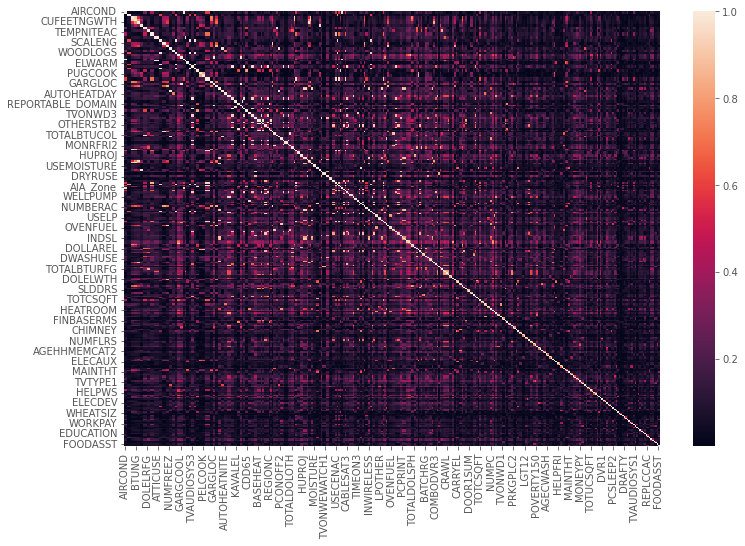

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(df_final.corr().abs())

Darker heatmap indicates a lower correlation between independent variables.

## Outliers

The variable response, KHW, has outliers. They should be dropped to avoid skewing the results. <br><br>
Six Sigma processes indicates that for the data to be in statistical contron it would be with 3*std from the mean. I will use that approach to eleminate rows with outliares.

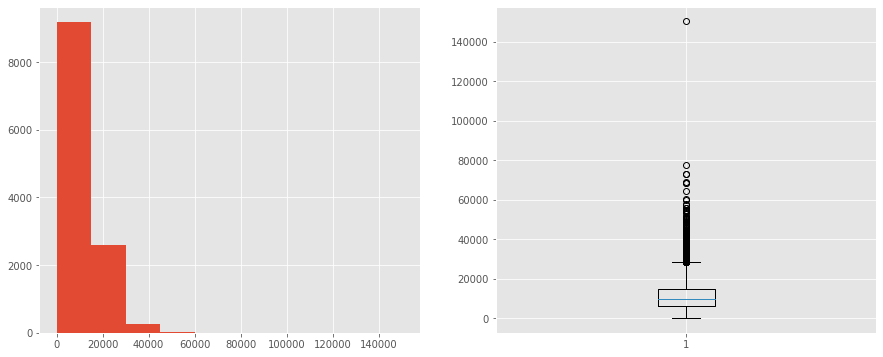

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].hist(df_final['KWH'])
ax[1].boxplot(df_final['KWH'])
plt.show()

Remove rows that have a zscore greater than 3, meaning 3*stardard deviations.

In [23]:
outliers = list(df_final[(np.abs(stats.zscore(df_final['KWH'])) > 3)].index)
df_final = df_final.loc[~df_final.index.isin(outliers)]

In [24]:
df_final.reset_index(drop=True, inplace=True)

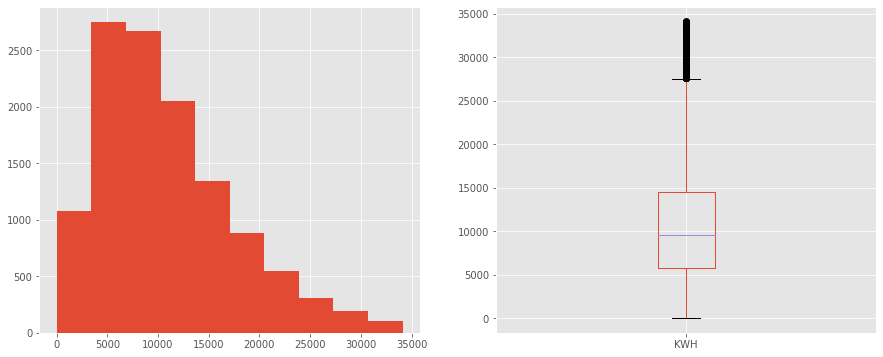

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].hist(df_final['KWH'])
df_final.boxplot('KWH')
plt.show()

Response is not linear, that's a problem when doing a Linear Regression. Nothing will be done about this non-linearity. I could normalize the 'KWH' column in order to improve that in case the linear regression is unsatisfactory.

In [26]:
df_final.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11923 entries, 0 to 11922
Data columns (total 338 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    AIRCOND             11923 non-null  int64  
 1    ELCOOL              11923 non-null  int64  
 2    CORDSWD             11923 non-null  float64
 3    BTUWOOD             11923 non-null  int64  
 4    BTUNGSPH            11923 non-null  float64
 5    CUFEETNGSPH         11923 non-null  float64
 6    CUFEETNG            11923 non-null  int64  
 7    BTUNG               11923 non-null  int64  
 8    CUFEETNGWTH         11923 non-null  float64
 9    BTUNGWTH            11923 non-null  float64
 10   CUFEETNGOTH         11923 non-null  float64
 11   BTUNGOTH            11923 non-null  float64
 12   DOLELCOL            11923 non-null  float64
 13   TOTALDOLCOL         11923 non-null  int64  
 14   DOLELRFG            11923 non-null  float64
 15   TOTALDOLRFG         11923 non-null

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


### Machine Learning 

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [28]:
X = df_final.drop('KWH', axis=1).values
y = df_final['KWH'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
lm = LinearRegression()

In [31]:
score = lm.fit(X_train, y_train).score(X_test, y_test)
print("Regression score: {:.2%}".format(score))

Regression score: 98.85%


In [32]:
predictions = lm.predict(X_test)

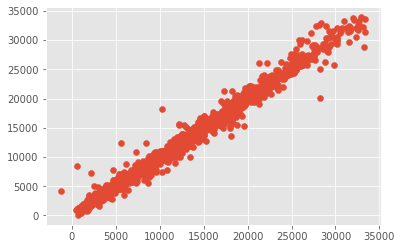

In [33]:
plt.scatter(predictions, y_test,)

In [34]:
import random
random.seed(500)
random_ind = random.randint(0,len(df))

new_values = df_final.drop('KWH',axis=1).iloc[random_ind]

new_values

AIRCOND         0.0
ELCOOL          0.0
CORDSWD         0.0
BTUWOOD         0.0
BTUNGSPH    12377.6
             ...   
ICE             1.0
VCR1            1.0
DVD1            1.0
FOODASST        0.0
HELPHT         -2.0
Name: 7562, Length: 337, dtype: float64

In [35]:
pred = lm.predict(new_values.values.reshape(1,337)).astype("float32")
actual = df.iloc[random_ind]['KWH']

print("Predicted: {} \nActual: {}".format(pred,actual))

Predicted: [5266.701] 
Actual: 5110


## Conclusions

1- The regression model has a 98% score, which is very good. <br>
2- The process of analysis is simple in steps, but it demonstrated to be tougher than expected. The additional columns with 'KWH', 'BTU' and 'DOL' were helping the model create a perfect regression. They had to be completely excluded.<br>
3- The challenge took about 4-5 hours, more than the allocated 2 hrs. The main code with machine learning took about 2 hrs, but I had trouble finding all columns that would allow the regression process to cheat.<br>
